## Multi-armed bandits

### 1. Load python packages

In [1]:
from typing import List 
import random
from dataclasses import dataclass
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd 
from IPython.display import display, HTML
from IPython.display import Image
%matplotlib inline

In [2]:
Image(url='img/multi_armed_bandits.jpg', width=400)

> The name comes from imagining a gambler at a row of slot machines (also known as __"one-armed bandits"__), who has to decide which machines to play, how many times to play each machine and in which order to play them, and whether to continue with the current machine or try a different machine.
> _Source: Wikipedia_

### 2. The problem

$\;\;\;\;\;\;$ - You have __'K' slot machines__ that you can play

$\;\;\;\;\;\;$ - You have __'N' coins__ (trials) to play in any machine you choose.

$\;\;\;\;\;\;$ - You know that __some machines pay more than the others__ but you dont know wich one.

$\;\;\;\;\;\;$ - Your goal is to __make as much money as possible__ playing with the 'coins' you have.

### 3. What a solution looks like

At beggining of each round you have two choices:

__a.__ Pick the machine that pays best among the ones that you already played. __(Exploit)__

__b.__ Pick a machine at random, and try to lean more about the setup. __(Explore)__


This problem requires that you define a __policy__ to decide how to choose either __'a'__ and __'b'__.


#### 3.1 The constants for our problem

In [3]:

@dataclass
class ExperimentParams:
    # The expected pay for each slot machine
    bandit_expectations: List[float]
    # Number of times we are repeating the experiment to we can average results.
    trials: int
    # Number the steps (coins) for each experiment
    number_of_steps: int 

params = ExperimentParams(
    bandit_expectations = [0.21, 0.5, 0.11, 1.00, 0.04, 0.64, 2.20, 0.65, 1.32, 0.27],
    trials = 500,
    number_of_steps = 1200)  
    


### 3. The $\epsilon$-greedy algorithm

#### 3.3 Helper classes to show report results.

#### 3.2 Import our packages

We assume we have N arms, 'N' being a constant. 

Let's make N=10

$\epsilon$ = input parameter that corresponds to the probability of __Exploring__ (option b)

#### 3.1 Here is a description of the policy:

- Define an array of values representing the percentage_pay for each arm ($arm_1$ to $arm_10$) 

- Initialize this array with 'zero' values at the beginning as we dont know anytihng about the arms yet.

- Keep the 'total_winnings' and 'total_coins_used' as the "game" progress.

- for each coin:
    * Pick a random number between 0 and 1.
    * If the number < $\epsilon$ then we choose __option b (explore)__
    * Otherwise we choose __option a (exploit)__
    * Update the counts.


#### 3.3 Helper classes to perform Multi-Armed bandit experiments

In [4]:
from abc import ABC, abstractmethod

@dataclass
class RewardRecs:
    title: str
    reward_list: List[float]
    avg_arm_counts: List[int]


class MultiArmBandit(ABC):
    """
    Multi-arm Base class.
    """
    def __init__(self, num_coins: int, mu_list: List[float]):
        self.number_of_arms = len(mu_list)
        self.mu_list = mu_list.copy()
        self.num_coins = num_coins
        self.used_coins = None
        self.step_rewards = None
        self.arm_counts = None
        self.arm_rewards = None
        self.mean_reward = None
        self.reset()
        
    def reset(self):
        self.used_coins = 0
        self.step_rewards = np.zeros(self.num_coins)
        self.arm_counts = np.zeros(self.number_of_arms)
        self.arm_rewards = np.zeros(self.number_of_arms)
        self.mean_reward = 0
        

    @abstractmethod
    def select_arm(self):
        pass

    def is_first_coin(self):
        return self.used_coins == 0
    
    def pull(self, arm, coin):
        reward = np.random.normal(self.mu_list[arm], 1)
        # Update counts
        self.used_coins += 1
        self.arm_counts[arm] += 1
        # Update rewards values
        self.mean_reward = self.mean_reward + (reward - self.mean_reward) / self.used_coins
        self.arm_rewards[arm] = ( self.arm_rewards[arm] + 
           (reward - self.arm_rewards[arm]) / self.arm_counts[arm])
        self.step_rewards[coin] = self.mean_reward

    def run(self):
        for coin in range(self.num_coins):
            selected_arm = self.select_arm()
            self.pull(selected_arm, coin)


class BanditExperiment(ABC):
    format_func = '{:,.2f}'.format

    def __init__(self, bandit_mus, trials, num_steps):
        self.bandit_mus = np.array(bandit_mus)
        self.trials = trials 
        self.num_steps = num_steps
        self.rewards_recs = []

    def plot(self):
        self.plot_custom(self.rewards_recs, self.trials)

    def tabulate(self):
        self.tabulate_custom(self.rewards_recs)

    def plot_custom(self, reward_recs, trials):
        color_list = ['b', 'c', 'r', 'y', 'g', 'k']
        plt.figure(figsize=(6.5,4))
        for idx, epx_rec in enumerate(reward_recs):
            plt.plot(
                epx_rec.reward_list, color=color_list[idx],
                label=epx_rec.title)
        plt.legend(bbox_to_anchor=(1.4, 1.0))
        plt.xlabel("Play")
        plt.ylabel("Average Reward")
        plt.title(f"Average Rewards after {trials} trials")
        plt.show()

    def tabulate_custom(self, reward_recs):
        saved_format = pd.options.display.float_format
        pd.options.display.float_format = self.format_func
        number_of_arms = len(self.bandit_mus)
        arm_counts = np.array([rec.avg_arm_counts for rec in reward_recs])
        perc_arm_counts = [((avg_ct/np.sum(avg_ct))*100.0).astype(float) for avg_ct in arm_counts]
        titles = [rec.title for rec in reward_recs] 
        arm_columns = ["Arm " + str(x) for x in range(1, number_of_arms+1)]
        arm_props_dict = {
            arm_columns[idx]: [
                '{0:.2f}'.format(self.bandit_mus[idx])] for idx, _ in enumerate(self.bandit_mus)
        }
        arm_df = pd.DataFrame(arm_props_dict, index=['$Probability$'])
        display(HTML("<b>Probability of each Arm:</b>"))
        display(HTML(arm_df.to_html()))        
        df = pd.DataFrame(perc_arm_counts, index=titles, columns=arm_columns)
        display(HTML("<br><b>Percentage of actions selected:</b>"))
        display(HTML(df.to_html()))
        pd.options.display.float_format = saved_format

        
    def capture_experiment(self, exp_title: str, bandit: MultiArmBandit):
        rewards = np.zeros(self.num_steps)
        arm_counts = np.zeros(len(self.bandit_mus))
        for trial_num in range(1, self.trials+1):
            # bandit = EpsilonGreedyBandit(curr_prob, self.num_steps, self.mu_list)
            bandit.reset()
            bandit.run()
            rewards = rewards + (bandit.step_rewards - rewards) / trial_num
            arm_counts = arm_counts + (bandit.arm_counts - arm_counts) / trial_num
        self.rewards_recs.append(
            RewardRecs(title=exp_title, reward_list=rewards, avg_arm_counts=arm_counts))
        
    @abstractmethod
    def execute_experiment(self):
        '''This is where the code for each specific experiment goes'''
        pass
    
    
    def run(self):
        self.execute_experiment()
        self.plot()
        self.tabulate()
        

#### 3.4 The $\epsilon$-Greedy policy implementation

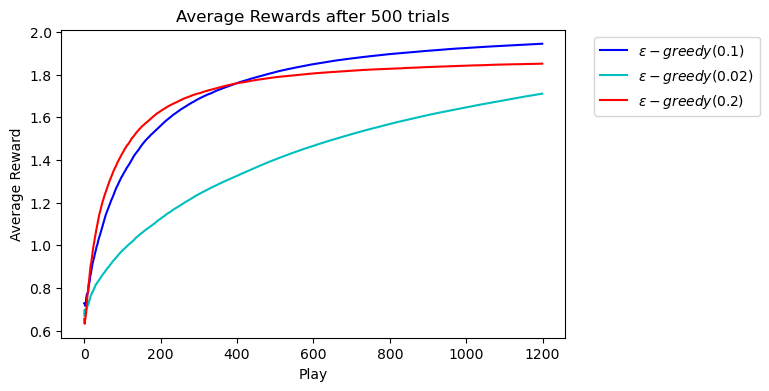

,Arm 1,Arm 2,Arm 3,Arm 4,Arm 5,Arm 6,Arm 7,Arm 8,Arm 9,Arm 10
$Probability$,0.21,0.50,0.11,1.00,0.04,0.64,2.20,0.65,1.32,0.27


,Arm 1,Arm 2,Arm 3,Arm 4,Arm 5,Arm 6,Arm 7,Arm 8,Arm 9,Arm 10
$\epsilon-greedy (0.1)$,1.35,1.58,1.16,2.85,1.09,1.70,82.33,1.46,5.33,1.15
$\epsilon-greedy (0.02)$,1.65,3.67,0.81,10.63,0.43,3.09,60.74,2.38,15.85,0.76
$\epsilon-greedy (0.2)$,2.26,2.22,2.09,2.83,2.06,2.27,78.20,2.27,3.71,2.09


In [5]:
class EpsilonGreedyBandit(MultiArmBandit):
    """
    Epsilon-Greedy multi-armed bandit processor

    mu_list: list of average reward for each arm.
    """

    def __init__(self, explore_prob: float, num_coins: int, mu_list: List[float]):
        super().__init__(num_coins, mu_list)     
        self.explore_prob = explore_prob

    def select_arm(self):
        '''Implement Epsilon Greedy policy'''
        curr_val = np.random.rand()
        if self.is_first_coin():
            # Know nothing at this point, just pick an arm.
            arm = np.random.choice(self.number_of_arms)
        elif curr_val < self.explore_prob:  
            # Select an arm randomly
            arm = np.random.choice(self.number_of_arms)
        else:  
            # Continue to exploit the best (the greedy component)
            arm = np.argmax(self.arm_rewards)
        return arm
        
 
class EpsilonGreedyExperiment(BanditExperiment):
    def __init__(self, probs_to_explore, bandit_mus, trials, num_steps):
        super().__init__(bandit_mus, trials, num_steps)    
        self.probs_explore = probs_to_explore
        
   
    def execute_experiment(self):
        for curr_prob in self.probs_explore:
            bandit = EpsilonGreedyBandit(curr_prob, self.num_steps, self.bandit_mus)
            exp_title = "$\epsilon-greedy ({0})$".format(curr_prob)
            self.capture_experiment(exp_title, bandit)
        

random.seed(10)
# We want to see how the policy behaves with different epsilon values
probs_to_explore = [0.1, 0.02, 0.2]
exp_greedy = EpsilonGreedyExperiment(
    bandit_mus = params.bandit_expectations,
    trials = params.trials, 
    probs_to_explore = probs_to_explore,
    num_steps = params.number_of_steps)
exp_greedy.run()
e_greedy_records = exp_greedy.rewards_recs


#### 3.5 The $\epsilon$-greedy approach limitations 

##### The $\epsilon$-greedy algorithm has two main limitations:

* It requires to provide a parameter as input that is unknown.
* As game progresses, we know more about the behavior of each machine, we dont adjust the value of $\epsilon$

### 4. The $\epsilon$-decay algorithm (A better solution)

Let's make $\epsilon$ variable in a way that it decreases as we use more coins.

Setting a value of $\epsilon$ as function of the trial number

$$ \epsilon(n) = \frac{1}{1+n\beta}$$

Where $\beta<1$ is a is scalling factor used to control how fast we reduce $\epsilon$.

#### 4.1 Implementation of the $\epsilon$-Decay policy

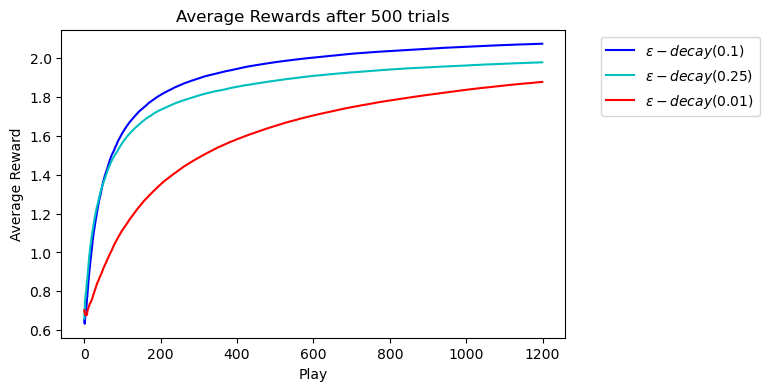

,Arm 1,Arm 2,Arm 3,Arm 4,Arm 5,Arm 6,Arm 7,Arm 8,Arm 9,Arm 10
$Probability$,0.21,0.50,0.11,1.00,0.04,0.64,2.20,0.65,1.32,0.27


,Arm 1,Arm 2,Arm 3,Arm 4,Arm 5,Arm 6,Arm 7,Arm 8,Arm 9,Arm 10
$\epsilon-decay (0.1)$,0.43,0.47,0.42,1.27,0.41,0.50,89.42,0.48,6.14,0.45
$\epsilon-decay (0.25)$,0.26,0.43,0.24,4.38,0.24,1.32,79.72,0.87,12.29,0.25
$\epsilon-decay (0.01)$,2.13,2.14,2.16,2.20,2.13,2.16,80.42,2.14,2.38,2.14


In [6]:
class EpsilonDecayBandit(MultiArmBandit):
    """
    Epsilon-Decay multi-armed bandit processor

    mu_list: list of average reward for each arm.
    """

    def __init__(self, beta: float, num_coins: int, mu_list: List[float]):
        super().__init__(num_coins, mu_list)
        self.beta = beta

    def select_arm(self):
        '''Implement Epsilon Decay policy'''
        curr_val = np.random.rand()
        explore_prob = 1 / (1 + (self.used_coins * self.beta))
        if self.used_coins == 0:
            # Know nothing at this point, just pick an arm.
            arm = np.random.choice(self.number_of_arms)
        elif curr_val < explore_prob:  
            # Select an arm randomly
            arm = np.random.choice(self.number_of_arms)
        else:  
            # Continue to exploit the best (the greedy component)
            arm = np.argmax(self.arm_rewards)
        return arm
        


class EpsilonDecayExperiment(BanditExperiment):
    def __init__(self, bandit_mus, trials, num_steps, betas):
        super().__init__(bandit_mus, trials, num_steps)
        self.betas = betas
        
   
    def execute_experiment(self):
        for beta in self.betas:
            bandit = EpsilonDecayBandit(beta, self.num_steps, self.bandit_mus)
            exp_title = "$\epsilon-decay ({0})$".format(beta)
            self.capture_experiment(exp_title, bandit)
        

random.seed(10)
# We want to see how the policy behaves with different epsilon values
number_of_arms = len(params.bandit_expectations)
exp_decay = EpsilonDecayExperiment(
    bandit_mus = params.bandit_expectations,
    trials = params.trials, 
    num_steps = params.number_of_steps,
    betas = [x / number_of_arms for x in (1, 2.5, 0.1)]
)
exp_decay.run()


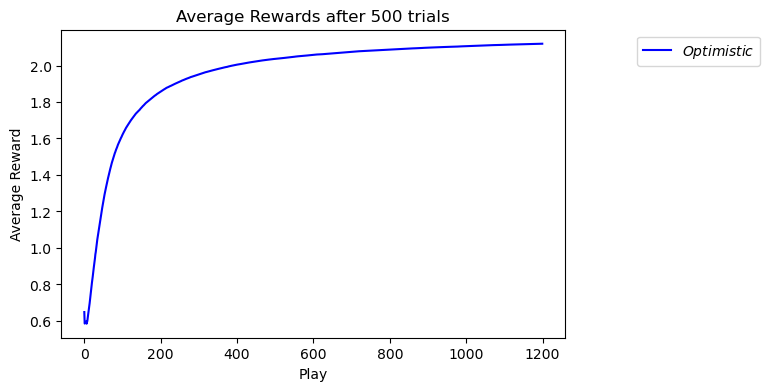

,Arm 1,Arm 2,Arm 3,Arm 4,Arm 5,Arm 6,Arm 7,Arm 8,Arm 9,Arm 10
$Probability$,0.21,0.50,0.11,1.00,0.04,0.64,2.20,0.65,1.32,0.27


,Arm 1,Arm 2,Arm 3,Arm 4,Arm 5,Arm 6,Arm 7,Arm 8,Arm 9,Arm 10
$Optimistic$,0.58,0.60,0.57,0.67,0.57,0.61,94.40,0.61,0.80,0.59


In [7]:
class OptimisticBandit(EpsilonDecayBandit):
    """
    Optimiatic multi-armed bandit processor
    """
    def reset(self):
        super().reset()
        self.arm_counts = np.ones(self.number_of_arms)
        self.arm_rewards = oiv_init = np.repeat(5., self.number_of_arms)
        

class OptimisticExperiment(BanditExperiment):
    def __init__(self, bandit_mus, trials, num_steps):
        super().__init__(bandit_mus, trials, num_steps)
        
   
    def execute_experiment(self):
        beta = 0.1
        bandit = OptimisticBandit(beta, self.num_steps, self.bandit_mus)
        self.capture_experiment("$Optimistic$", bandit)
        

random.seed(10)
# We want to see how the policy behaves with different epsilon values
number_of_arms = len(params.bandit_expectations)
exp_opt = OptimisticExperiment(
    bandit_mus = params.bandit_expectations,
    trials = params.trials, 
    num_steps = params.number_of_steps
)
exp_opt.run()


### 5. Looking at the best results combined

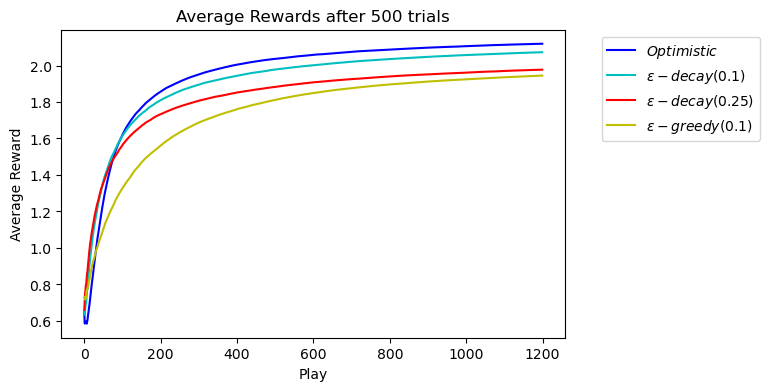

,Arm 1,Arm 2,Arm 3,Arm 4,Arm 5,Arm 6,Arm 7,Arm 8,Arm 9,Arm 10
$Probability$,0.21,0.50,0.11,1.00,0.04,0.64,2.20,0.65,1.32,0.27


,Arm 1,Arm 2,Arm 3,Arm 4,Arm 5,Arm 6,Arm 7,Arm 8,Arm 9,Arm 10
$Optimistic$,0.58,0.60,0.57,0.67,0.57,0.61,94.40,0.61,0.80,0.59
$\epsilon-decay (0.1)$,0.43,0.47,0.42,1.27,0.41,0.50,89.42,0.48,6.14,0.45
$\epsilon-decay (0.25)$,0.26,0.43,0.24,4.38,0.24,1.32,79.72,0.87,12.29,0.25
$\epsilon-greedy (0.1)$,1.35,1.58,1.16,2.85,1.09,1.70,82.33,1.46,5.33,1.15


In [8]:
def select_top_x(exp_rec_list, number_of_curves):
    all_records = []
    for rec_list in exp_rec_list:
        all_records.extend(rec_list.rewards_recs.copy())
    result = sorted(all_records, key=lambda x: -x.reward_list[-1])
    return result[:number_of_curves]

selected_curves = select_top_x([
    exp_greedy, 
    exp_decay, 
    exp_opt
], 4)
exp_decay.plot_custom(selected_curves, params.trials)
exp_decay.tabulate_custom(selected_curves)
